Здравствуй уважаемый ревьювер!!! Меня зовут Антон и я просто хочу поблагодарить тебя за то, что берешься проверить мою работу :-) 

# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Откроем файлы с данными и изучим общую информацию. 

In [1]:
import pandas as pd 
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv') 
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

for data in [calls, internet, messages, tariffs, users]:
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns

### Вывод

В датасете содержаться данные по 500 клиентам. В каждой таблице требуется заменить тип данных у столбцов с датой.
Кроме того, после объединения данных (будем создавать сводную таблицу по звонкам, сообщениям и интернет-трафику) могут возникнуть пропущенные значения (клиент мог не писать, не звнить или не пользоваться интернетом в течении месяца). Такие значения лучше всего будет заменить на нули.
Исходя из того, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов, многи значения о продолжительности звонков и интернет трафике нужно округлить в большую сторону.

### Шаг 2. Подготовка данных

### Замена типов данных

Заменим тип данных столбцов, обозначающих дату с типа *object* на тип *datetime*.

In [2]:
# calls['call_date'].head()

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

#for data in [calls, internet, messages, tariffs, users]:
#    print(data.info(), end='\n\n')

### Исправление ошибок в данных

#### Звонки

In [3]:
# Определим количество звонков, продолжительностью 0 минут.

print('Количество звонков с длительностью, равной нулю: ', len(calls.query('duration == 0')))

Количество звонков с длительностью, равной нулю:  39613


Постороим график зависимости количиества нулевых звонков от общего числа звонков за каждый месяц.

Text(0.5, 0, 'Общее число звонков')

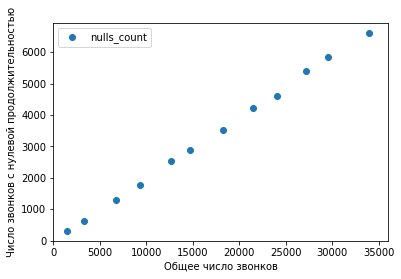

In [4]:
calls['month'] = calls['call_date'].dt.month

calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls.plot(x='id', y='nulls_count', style='o', xlim=(0, 36000))

plt.ylabel('Число звонков с нулевой продолжительностью')
plt.xlabel('Общее число звонков')

Как мы можем видеть, появление звонков с нулевой продолжительностью систематично, и их количество прямопропорционально общему числу звонков (что, в принципе, логично). Все знчения в столбце `duration` округлим в большую сторону (т.к. тариф считается по минутам), а нулевые значения заменим на 1.

In [5]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls.loc[calls['duration'] == 0, 'duration'] = 1
# calls.head(10)

#### Интернет

Text(0.5, 0, 'Общее число интернет-сессий')

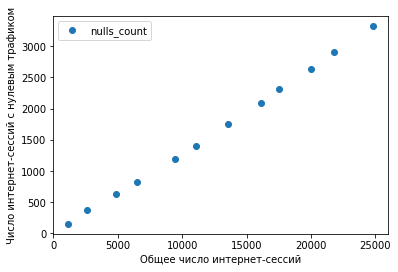

In [6]:
internet['month'] = internet['session_date'].dt.month

internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_internet = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_internet.plot(x='id', y='nulls_count', style='o', xlim=(0, 26000))

plt.ylabel('Число интернет-сессий с нулевым трафиком')
plt.xlabel('Общее число интернет-сессий')

Ситуация аналогична с продолжительностью разговора.
Все знчения в столбце `mb_used` округлим в большую сторону, а нулевые значения заменим на 1.

In [7]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1
# internet.head(10)

### Расчетные значения для каждого пользователя

Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.

In [8]:
calls_group = calls.pivot_table(index=['user_id', 'month'], values=['duration', 'id'], aggfunc={'duration': 'sum', 'id': 'count'})
calls_group.columns = ['duration', 'calls']
calls_group.head(10)

duration  calls
user_id month                 
1000    5         164.0     22
        6         187.0     43
        7         346.0     47
        8         418.0     52
        9         478.0     58
        10        363.0     57
        11        344.0     43
        12        341.0     46
1001    11        444.0     59
        12        430.0     63

Количество отправленных сообщений по месяцам.

In [9]:
messages['month'] = messages['message_date'].dt.month
messages_group = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_group.columns = ['messages_count']
messages_group.head(10)

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
        10                 73
        11                 58
        12                 70
1002    6                   4
        7                  11

Объем израсходованного интернет-трафика по месяцам.

In [10]:
internet_group = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_group.head(10)

mb_used
user_id month         
1000    5       2257.0
        6      23262.0
        7      14017.0
        8      14072.0
        9      14583.0
        10     14717.0
        11     14769.0
        12      9829.0
1001    11     18460.0
        12     14059.0

Объединим все три сводные таблицы в одну.

In [11]:
grouped = calls_group.merge(messages_group, on=['user_id', 'month'], how='outer')
grouped = grouped.merge(internet_group, on=['user_id', 'month'], how='outer')
grouped.head(10)

duration  calls  messages_count  mb_used
user_id month                                          
1000    5         164.0   22.0            22.0   2257.0
        6         187.0   43.0            60.0  23262.0
        7         346.0   47.0            75.0  14017.0
        8         418.0   52.0            81.0  14072.0
        9         478.0   58.0            57.0  14583.0
        10        363.0   57.0            73.0  14717.0
        11        344.0   43.0            58.0  14769.0
        12        341.0   46.0            70.0   9829.0
1001    11        444.0   59.0             NaN  18460.0
        12        430.0   63.0             NaN  14059.0

Буду безумно благодарен, если подскажете, как более правильно применить метод *join* для объединения сразу трех таблиц.
И можно ли как то сделать, что бы значение `user_id` стояло с самой первой строчки для каждого подпункта по пользователям, а не уплывало куда-то в серединку. :-)

In [12]:
# Проверим количество пропущенных значений.
grouped.isna().sum()

duration           40
calls              40
messages_count    497
mb_used            11
dtype: int64

Как мы уже говорили ранее, все пропущенные значения можно описать тем, что в некоторые месяцы абонент попросту не пользовался определенными видами услуг. Следовательно наилучшим вариантом будет замена пропущенных значений на нули.

In [13]:
grouped['duration'] = grouped['duration'].fillna(0)
grouped['calls'] = grouped['calls'].fillna(0)
grouped['messages_count'] = grouped['messages_count'].fillna(0)
grouped['mb_used'] = grouped['mb_used'].fillna(0)

Определим помесячную выручку с каждого пользователя.

In [14]:
# Добавим столбец с наименование тарифа
for user in grouped.index:
    grouped.loc[user, 'tariff_name'] = users.loc[user[0] - 1000, 'tariff']

grouped.head(10)

# Очень корявый способ, может есть еще вариант?

duration  calls  messages_count  mb_used tariff_name
user_id month                                                      
1000    5         164.0   22.0            22.0   2257.0       ultra
        6         187.0   43.0            60.0  23262.0       ultra
        7         346.0   47.0            75.0  14017.0       ultra
        8         418.0   52.0            81.0  14072.0       ultra
        9         478.0   58.0            57.0  14583.0       ultra
        10        363.0   57.0            73.0  14717.0       ultra
        11        344.0   43.0            58.0  14769.0       ultra
        12        341.0   46.0            70.0   9829.0       ultra
1001    11        444.0   59.0             0.0  18460.0       smart
        12        430.0   63.0             0.0  14059.0       smart

In [15]:
def profit(row):
    duration = row['duration']
    calls = row['calls']
    messages_count = row['messages_count']
    mb_used = row['mb_used']
    tariff = row['tariff_name']
    
    if tariff == 'smart':
        surplus_minute = duration - tariffs.loc[0, 'minutes_included']
        surplus_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        surplus_messages = messages_count - tariffs.loc[0, 'messages_included']
        
        # Отрицательные значения приравняем к нулю, т.к. абонент не превысил норму тарифного пакета
        if surplus_minute < 0:
            surplus_minute = 0
        if surplus_mb < 0:
            surplus_mb = 0
        if surplus_messages < 0:
            surplus_messages = 0
         
        return (tariffs.loc[0, 'rub_per_minute'] * surplus_minute 
                + (tariffs.loc[0, 'rub_per_gb'] /1024) * surplus_mb
                + tariffs.loc[0, 'rub_per_message'] * surplus_messages
                + tariffs.loc[0, 'rub_monthly_fee']
               )


    else:
        surplus_minute = duration - tariffs.loc[1, 'minutes_included']
        surplus_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        surplus_messages = messages_count - tariffs.loc[1, 'messages_included']

        if surplus_minute < 0:
            surplus_minute = 0
        if surplus_mb < 0:
            surplus_mb = 0
        if surplus_messages < 0:
            surplus_messages = 0

        return (tariffs.loc[1, 'rub_per_minute'] * surplus_minute 
                + (tariffs.loc[1, 'rub_per_gb'] /1024) * surplus_mb
                + tariffs.loc[1, 'rub_per_message'] * surplus_messages
                + tariffs.loc[1, 'rub_monthly_fee']
               )            
            
grouped['profit'] = grouped.apply(profit, axis=1)    

In [16]:
grouped['profit'] = round(grouped['profit'], 2)
grouped.head(15)

duration  calls  messages_count  mb_used tariff_name   profit
user_id month                                                               
1000    5         164.0   22.0            22.0   2257.0       ultra  1950.00
        6         187.0   43.0            60.0  23262.0       ultra  1950.00
        7         346.0   47.0            75.0  14017.0       ultra  1950.00
        8         418.0   52.0            81.0  14072.0       ultra  1950.00
        9         478.0   58.0            57.0  14583.0       ultra  1950.00
        10        363.0   57.0            73.0  14717.0       ultra  1950.00
        11        344.0   43.0            58.0  14769.0       ultra  1950.00
        12        341.0   46.0            70.0   9829.0       ultra  1950.00
1001    11        444.0   59.0             0.0  18460.0       smart  1155.47
        12        430.0   63.0             0.0  14059.0       smart   550.00
1002    6         118.0   15.0             4.0  10878.0       smart   550.00
        7         219.0   26.0            11.0  17615.0       smart   990.43
        8         294.0   42.0            13.0  20357.0       smart  1525.98
        9         217.0   36.0             4.0  16724.0       smart   816.41
        10        221.0   33.0            10.0  13913.0       smart   550.00

### Шаг 3. Анализ данных

Определим, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт.

In [17]:
grouped_median = grouped.pivot_table(index='user_id', 
                                     values=['duration', 'messages_count', 'mb_used', 'profit'], 
                                     aggfunc='median')

# Добавим столбец с наименованием тарифа
grouped_median = grouped_median.merge(users[['user_id', 'tariff']], on='user_id')
grouped_median.head(10)

,user_id,duration,mb_used,messages_count,profit,tariff
0,1000,345.0,14327.5,65.0,1950.000,ultra
1,1001,437.0,16259.5,0.0,852.735,smart
2,1002,221.0,17615.0,11.0,990.430,smart
3,1003,844.0,11369.0,83.0,1950.000,ultra
4,1004,136.5,17831.0,154.5,1950.000,ultra
5,1005,609.5,7846.5,49.0,884.500,smart
6,1006,365.0,15554.0,0.0,587.890,smart
7,1007,490.0,14451.0,26.0,881.840,smart
8,1008,350.0,13243.0,56.0,568.000,smart
9,1009,228.0,17762.0,12.0,1019.140,smart


Найдем медиану, дисперсию и стандартное отклонение.

In [18]:

stat = grouped_median.pivot_table(index='tariff', 
                                   values=['duration', 'messages_count', 'mb_used'],
                                  aggfunc={'duration': [np.median, np.var, np.std],
                                          'messages_count': [np.median, np.var, np.std],
                                          'mb_used': [np.median, np.var, np.std]})
stat

duration                             mb_used               \
         median         std           var    median          std   
tariff                                                             
smart     453.0  164.614327  27097.876586  16955.00  4181.498288   
ultra     550.5  311.491491  97026.949014  19751.75  8901.975727   

                     messages_count                          
                 var         median        std          var  
tariff                                                       
smart   1.748493e+07           28.5  28.010653   784.596662  
ultra   7.924517e+07           47.5  49.236809  2424.263318

In [19]:
# plt.bar(grouped_median['tariff'], grouped_median['duration'])

In [20]:
# plt.bar(grouped_median['tariff'], grouped_median['mb_used'])

In [21]:
# plt.bar(grouped_median['tariff'], grouped_median['messages_count'])

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


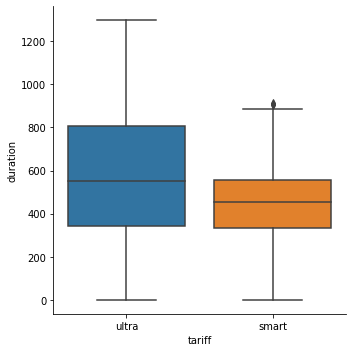

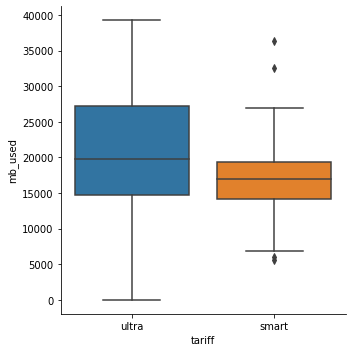

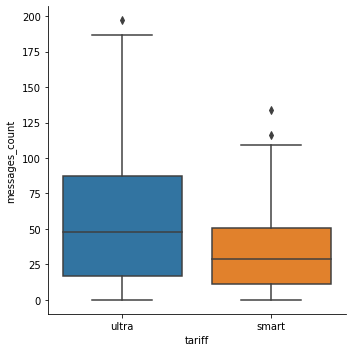

In [22]:
# Еще при работе с прошлым проектом начал осваивать библиотеку Seaborn
# по моему мнению она даёт более наглядные графики
import seaborn as sns

for column in ['duration', 'mb_used', 'messages_count']:
    sns.catplot(x='tariff', y=column, kind='box', data=grouped_median)

Как мы можем видеть, минуты разговора, количество потраченных мегабайтов и число сообщений по тарифу "Ультра" имеют большую дисперсию в сравнении с вышеперечисленными признаками по тарифу "Смарт". Кроме того, медианы по тарифу "Ультра" так же смещенны в большую сторону, а выбросов в рамках более дешевого тарифа существенно больше.

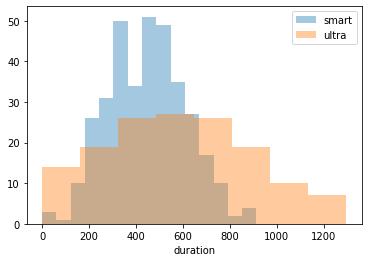

In [23]:
for tariff in ['smart', 'ultra']:
    sns.distplot(grouped_median.query('tariff == @tariff')['duration'], kde=False)
plt.legend(['smart', 'ultra'])

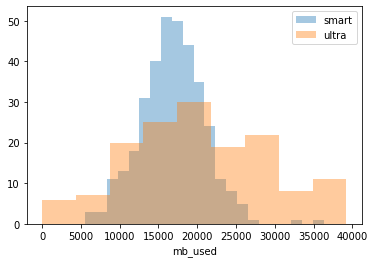

In [24]:
for tariff in ['smart', 'ultra']:
    sns.distplot(grouped_median.query('tariff == @tariff')['mb_used'], kde=False)
plt.legend(['smart', 'ultra'])

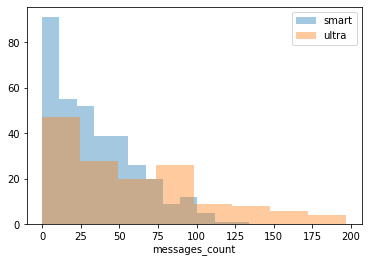

In [25]:
for tariff in ['smart', 'ultra']:
    sns.distplot(grouped_median.query('tariff == @tariff')['messages_count'], kde=False)
plt.legend(['smart', 'ultra'])

### Вывод

Как мы уже говорили ранее дисперсия по тарифу "Смарт" ниже в отличии от тарифа "Ультра" по всем исследуемым параметрам: по длительности разговора, количеству мегабайт используемого интернет-трафика и по количеству сообщений. Так же невооруженным глазом мы можем видеть, что мода у тарифа "Смарт" явно выражена.
Отсюда можно предположить, что пользователи тарифа "Ультра" более "свободны" в выборе того, как им использовать предоставленные ресурсы из тарифного пакета (с таким тарифом сложно думать о том, когда закончаться минуты разговора, мегабайты интернета или сообщения) 

## Шаг 4. Проверка гипотез

#### Нулевая гипотеза - "Средняя выручка пользователей тарифа «Ультра» равна средней выручка пользователей тарифа «Смарт» "

#### Альтернативная гипотеза - "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

In [26]:
ultra = grouped.query('tariff_name == "ultra"')['profit']
smart = grouped.query('tariff_name == "smart"')['profit']

alpha = .05

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  2.4533519468353593e-281
Отвергаем нулевую гипотезу


In [27]:
grouped.pivot_table(index='tariff_name', values='profit', aggfunc='median')

,profit
tariff_name,
smart,987.66
ultra,1950.00


Примерно в два раза различаются среднии выручки по тарифам. Можно сделать вывод, что если у абонента подключён тариф "Смарт", то по окончанию месяца он заплатит больше из-за нехватки услуг в рамках тарифного пакета.
Можем уверенно сказать, что доходы "Мегалайн" с пользователя по тарифу "Ультра" действительно отличаются по сравнению с доходами от "Смарта".

#### Нулевая гипотеза - "средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов "
#### Альтернативная гипотеза - "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

In [28]:
# Добавим столбец с названием населенного пункта.
for user in grouped.index:
    grouped.loc[user, 'city'] = users.loc[user[0] - 1000, 'city']
    
moscow = grouped.query('city == "Москва"')['profit']
region = grouped.query('city != "Москва"')['profit']

alpha = .05

results = st.ttest_ind(
    moscow, 
    region,
    equal_var=False)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.5030016583388277
Не получилось отвергнуть нулевую гипотезу


In [29]:
grouped['region'] = grouped['city'].where(grouped['city'] == "Москва", "Другой регион")

grouped.pivot_table(index='region', values='profit', aggfunc='median')

,profit
region,
Другой регион,1545.90
Москва,1733.59


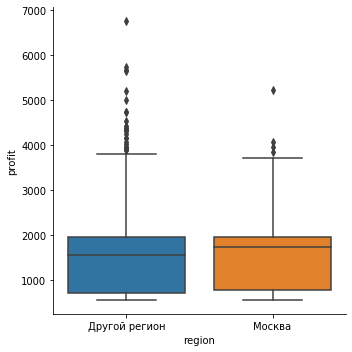

In [30]:
sns.catplot(x="region", y='profit', kind='box', data=grouped)

Наш статистический тест не дал возможности опровергнуть нулевую гипотезу о том, что выручка с пользователей из Москвы отличается от выручки из других регионов. Да и благодаря графику можем видеть, что выручка действительно не отличается.
Мы бы ошиблись с вероятностью 50.3%, если бы предположили, что выручка в Москве отличается от выручки в других регионах.

## Шаг 5. Общий вывод

Исходя из результатов статистического анализа можем сделать вывод, что доходы от тарифа "Ультра" больше, чем от тарифа "Смарт": в среднем "Мегалайн" от одного пользователя получает 1950 и 988 рублей соответственно.

 - Пользователям тарифа "Смарт" не хватает услуг в рамках их тарифного пакета и им приходится доплачивать в среднем 438 рублей, что соотвествует 79.6% от ежемесячной абоненсткой платы.
 - Пользователи тарифа "Ультра" не успевают за месяц использовать тарифный пакет в полном объеме.
 - Средний доход от пользователей в Москве не отличается от дохода в других населенных пунктах: разница статистически незначима (p-значение: 0,503) и составляет 188 рублей.

<div class="alert alert-success">
<h2> Комментарий</h2>

Рекомендую посмотреть на дополнительную стилизацию ячеек типа **markdown**.
    
**Жирный**
*Курсив*
    
--- 

# Заголовок первого уровня

--- 
    
## Заголовок первого уровня
  
--- 
Списки:
    
- один 
- два
- три
   
---
    
1. Раз
2. Раз раз
3. Раз два три
    
--- 
    
Отображение `переменных`
    
    
</div>